In [11]:
# check location of python3 for import statements
import sys
print(sys.executable)

/Users/tanviranade/anaconda3/bin/python


In [12]:
# import libraries
import random
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import RobustScaler
from scipy import stats
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix

**Sub-Sampling Patient Data [2]**

A patient is randomly chosen, random time intervals are chosen that add up to 3 minutes total, and each time interval is assigned to an activity (out of lying, sitting, standing, and walking). Then, the data for all the activity time intervals is pieced together to create a '3 minute story'.

In [13]:
# creates empty lists to hold sub-sampling data
sub_sampling_data = []
time_ranges = []
activities_by_patient = []
time_lengths = []
start_time_total = []

In [14]:
# iterates to create '3 minute stories' for 100 patients
for i in range(0, 100):

    # chooses random patient
    random_patient = random.choice(os.listdir("selfBack/w/lying"))

    # boolean to check if a certain random time interval has less than 5 seconds allocated to it
    less_than_5 = True

    # iterates as many times as needed to ensure there is no time interval less than 5 (seconds)
    while(less_than_5):

        # defines variables
        random_num_list = []
        less_than_5 = False
        sum = 0
        new_sum = 0

        # randomly decides how many segments there will be
        num_divisions = random.randint(4, 15)

        # iterates through loop to generate the random numbers and calculate their sum
        for a in range(0, num_divisions):
            rand_num = round(random.uniform(0, 1), 3)
            random_num_list.append(rand_num)
            sum += rand_num

        # iterates num_divisions number of times (1 per random number)
        for b in range(0, num_divisions):

            # divides each number by the sum and multiples by 180 to have them add up to 3 mins total
            random_num_list[b] /= (sum * 1/180)
            random_num_list[b] = round(random_num_list[b], 1)

            # assigns boolean to true if the value if a certain activity time length is less than 5.05 seconds
            if(random_num_list[b] < 5.05):
                less_than_5 = True
            
            # calculates updated sum
            new_sum += random_num_list[b]

        # resolves rounding issues
        new_sum = round(new_sum, 2)

        # if the sum does not add up to 3 minutes total, tweaks the value of the first number by the difference
        if (new_sum != 360):
            random_num_list[0] += 180 - new_sum
            random_num_list[0] = round(random_num_list[0], 1)

    # define the definite path (currently only w)
    definite_path = "selfBack/w/"

    # define list of possible activities to choose from
    activity_list_orig = ["lying", "sitting", "standing", "walk_slow", "walk_mod", "walk_fast"]

    # defines a starting activity list
    activity_list = ["lying", "sitting", "standing"]

    # creates a list with types of walking and randomly adds an element to the starting activity list
    walking_list = ["walk_slow", "walk_mod", "walk_fast"]
    activity_list.append(random.choice(walking_list))

    # adds a randomly chosen element from the defined list for every random number (other than the starting four)
    for c in range(len(random_num_list)):
        if(c > 3):
            activity_list.append(random.choice(activity_list_orig))

    # shuffles the list of activities to ensure randomness
    random.shuffle(activity_list)

    # defines a list to hold the start indices of each activity
    activity_time_stamps = []

    # defines list to hold names of each activity in actual order
    activities = []

    # creates a list to hold the time length per activity and initializes the values to 0
    time_per_activity = [0] * len(activity_list_orig)

    # defines a list to hold the start times of each activity
    start_time_per_activity = []

    # iterates through the list of random numbers
    for random_num_index in range(len(random_num_list)):
        
        # randomly choose activity out of list
        random_activity = random.choice(activity_list)

        # remove it from the original list to ensure it is not chosen multiple times
        activity_list.remove(random_activity)

        # read csv using pandas
        df_w = pd.read_csv(os.path.join(definite_path, random_activity, random_patient))

        # converts each column of the dataframe to a list
        x_vals_w = df_w['x'].tolist()
        y_vals_w = df_w['y'].tolist()
        z_vals_w = df_w['z'].tolist()
        time_list_w = df_w['time'].tolist()

        # iterates through the list with the time values, converts to time in seconds, and stores them in new list
        time_sec_vals_w = []
        for el in time_list_w:
            el = (el.split(" "))[1]
            time_split_w = el.split(":")
            time_secs_w = float(time_split_w[0]) * 3600 + float(time_split_w[1]) * 60 + float(time_split_w[2])
            time_sec_vals_w.append(time_secs_w)

        # creates pandas dataframe with time values in seconds, x, y, and z
        new_df_w = pd.DataFrame(list(zip(time_sec_vals_w, x_vals_w, y_vals_w, z_vals_w)), columns =['time', 'x', 'y', 'z'])
        
        # converts pandas dataframe into numpy array
        np_data_w = new_df_w.to_numpy()

        # converts all values in the array from strings to floats
        np_data_w = np_data_w.astype(float)

        # stores the current first and last times in the patient data
        first_time_w = np_data_w[0][0]
        last_index_w = len(np_data_w) - 1
        last_time_w = np_data_w[last_index_w][0]

        # appends the array to itself (twice as long of a time frame)
        np_data_w = np.append(np_data_w, np_data_w, axis=0)

        # randomly chooses a start time
        start_index_w = random.randint(0, last_index_w)
        start_time_w = np_data_w[start_index_w][0]

        # initializes end index var
        end_index_w = 0

        # fixes indices to make them continuous
        for d in range(len(np_data_w[:,0])):
            if(d > last_index_w):
                np_data_w[:,0][d] += last_time_w - first_time_w
            np_data_w[:,0][d] -= start_time_w

        # determines index to end at
        for e in range(len(np_data_w[:,0])):
            if((np_data_w[:,0])[e] > random_num_list[random_num_index]):
                end_index_w = e
                break
        
        # detemines end time based on index
        end_time_w = np_data_w[end_index_w][0]

        # detemines time per activity
        for f in range(len(activity_list_orig)):
            if (random_activity == activity_list_orig[f]):
                time_per_activity[f] += end_time_w

        # slices the dataset to only include relevant values (within specified time interval)
        np_data_w = np_data_w[start_index_w:end_index_w + 1, 0:4]
        
        # after the first iteration, adds the time that the last activity ended to the time values for continuity
        if (random_num_index != 0):
            np_data_w[:,0] = np_data_w[:,0] + elapsed_time_w

        # creates a column to store activity type
        activity_col = np.full((len(np_data_w), 1), random_activity)

        # appends column to the numpy array with patient data
        np_data_w = np.append(np_data_w, activity_col, axis=1)

        # creates a column to store patient number
        patient_col = np.full((len(np_data_w), 1), random_patient.split(".")[0])

        # appends column to the numpy array with patient data
        np_data_w = np.append(np_data_w, patient_col, axis=1)

        # creates a column to store start index (per activity)
        start_index_col = np.full((len(np_data_w), 1), start_index_w)

        # appends column to the numpy array with patient data
        np_data_w = np.append(np_data_w, start_index_col, axis=1)
 
        # creates a column to store user id
        start_index_col = np.full((len(np_data_w), 1), i)

        # appends column to the numpy array with patient data
        np_data_w = np.append(np_data_w, start_index_col, axis=1)

        # adds activity start time/index and patient data numpy array by activity based on their values during the current iteration
        if (random_num_index == 0):
            activity_time_stamps.append(0)
            full_numpy_array_w = np_data_w
            start_time_per_activity.append(0)
        else:
            activity_time_stamps.append(len(full_numpy_array_w))
            full_numpy_array_w = np.append(full_numpy_array_w, np_data_w, axis=0)
            start_time_per_activity.append(elapsed_time_w)
            
        # sets variable to value of current activity's end time (will be used during next iteration as start time)
        elapsed_time_w = float(np_data_w[len(np_data_w) - 1, 0])

        # adds current randomly chosen activity to list storing activity occurrences in order
        activities.append(random_activity)

    # adds values from a patients data to a list storing data for every patient sampling
    sub_sampling_data.append(full_numpy_array_w)
    time_ranges.append(activity_time_stamps)
    activities_by_patient.append(activities)
    time_lengths.append(time_per_activity)
    start_time_total.append(start_time_per_activity)

    # creates a list that holds the data in the formal needed for ml
    if (i == 0):
        ml_format = full_numpy_array_w
    
    else:
        ml_format = np.append(ml_format, full_numpy_array_w, axis=0)

**Data Analysis [3]**

Patient data is displayed -- currently in table and line graph form. The outputs shown correspond to the first patient's '3 minute story', with each component of acceleration shown as a different color in the graph with respect to time. Activity types and their corresponding time intervals are marked.

First 5 Rows
              timestamp     x_axis    y_axis    z_axis  activity patient   
0                   0.0      -0.75   0.21875    0.4375  walk_mod     050  \
1  0.010000000002037268    -0.6875  0.234375    0.4375  walk_mod     050   
2   0.01999999999679858  -0.640625  0.234375   0.46875  walk_mod     050   
3  0.029999999998835847  -0.609375      0.25  0.484375  walk_mod     050   
4  0.040000000000873115   -0.59375      0.25  0.484375  walk_mod     050   

  start_index user_id  
0        4418       0  
1        4418       0  
2        4418       0  
3        4418       0  
4        4418       0  

Last 5 Rows
                timestamp     x_axis    y_axis    z_axis activity patient   
17744   179.9989999999816       -1.0       0.0  -0.03125    lying     050  \
17745  180.00899999998364  -1.015625  0.015625  -0.03125    lying     050   
17746  180.01899999998568       -1.0       0.0  -0.03125    lying     050   
17747  180.02899999998044  -1.015625  0.015625  -0.03125    lying

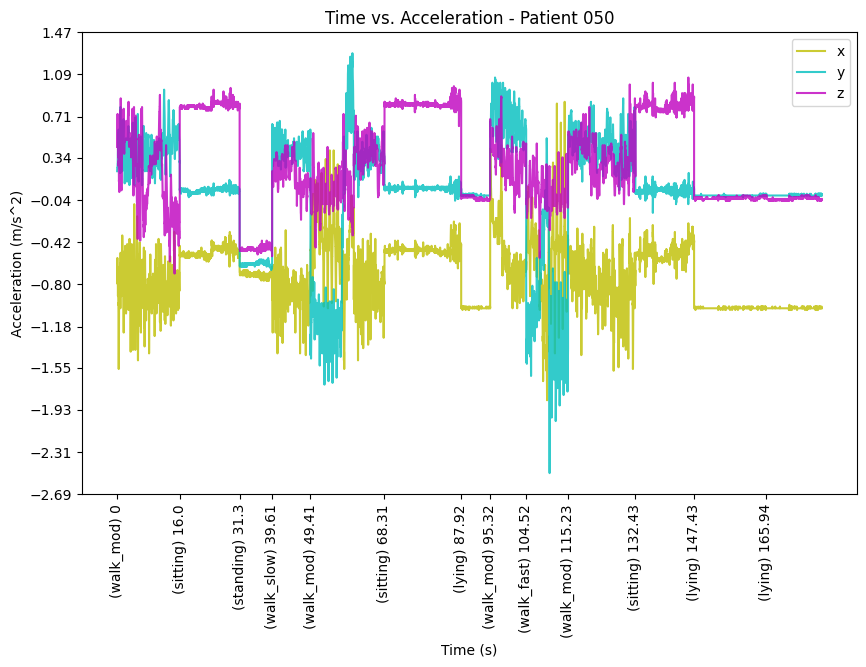

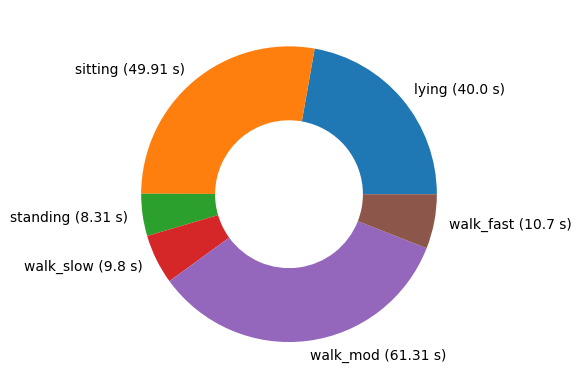

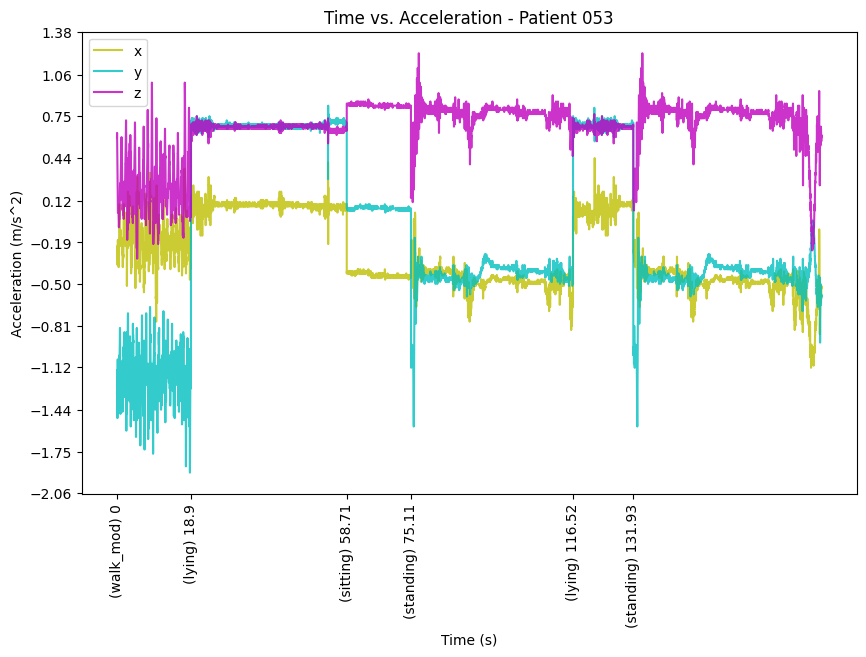

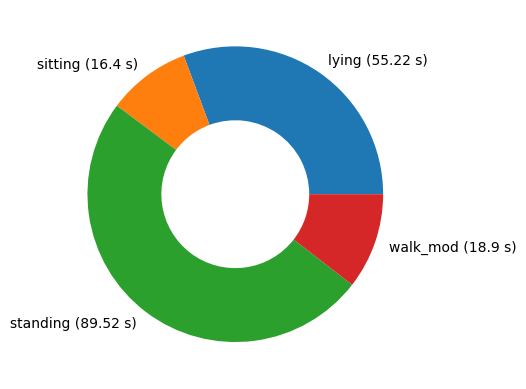

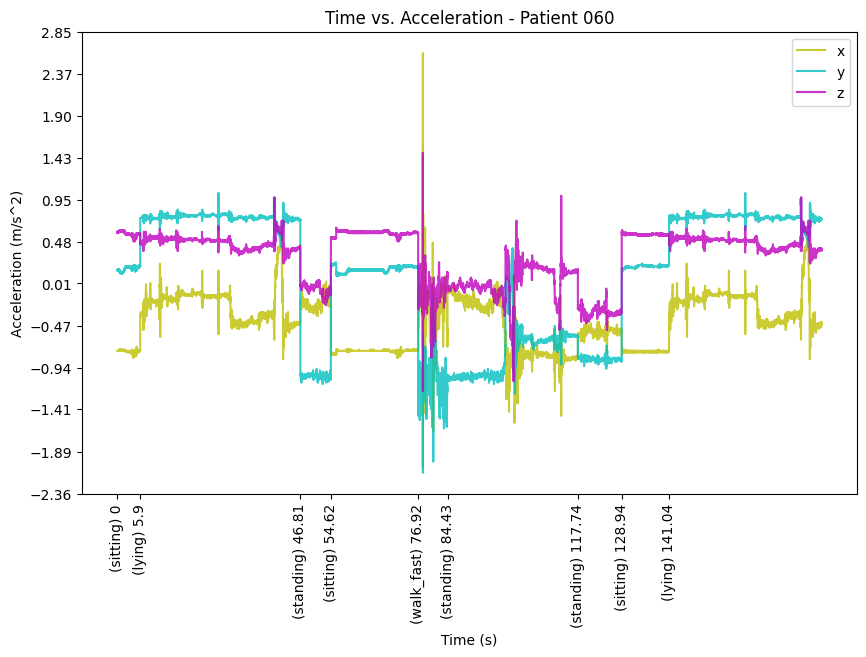

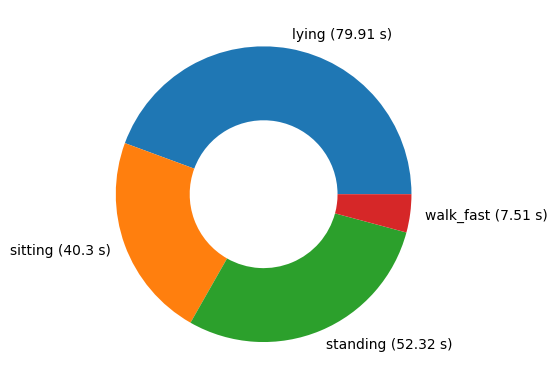

In [25]:
# creates pandas dataframe for first patient's processed data
output = pd.DataFrame(sub_sampling_data[0], columns = ['timestamp','x_axis','y_axis','z_axis', 'activity', 'patient', 'start_index', 'user_id'])

# outputs first patient's processed data -- first 5 rows
print("First 5 Rows")
print(output.head())

# outputs first patient's processed data -- last 5 rows
print("\nLast 5 Rows")
print(output.tail())

# iterates through desired number of patients
for i in range(0,3):

    # creates a list holding only the current patient's data
    single_patient_data = sub_sampling_data[i]

    # creates lists holding each column of the first patient's processed data
    time = single_patient_data[:,0].astype(float)
    x = single_patient_data[:,1].astype(float)
    y = single_patient_data[:,2].astype(float)
    z = single_patient_data[:,3].astype(float)

    # changes figure size to make it larger than default
    plt.figure(figsize=(10,6))

    # calls plotting function for each series (x, y, and z) with time on the x-axis
    plt.plot(time, x, label = 'x', color='y', alpha=0.8)
    plt.plot(time, y, label = 'y', color='c', alpha=0.8)
    plt.plot(time, z, label = 'z', color='m', alpha=0.8)

    # sets title of graph
    title = "Time vs. Acceleration - Patient " + str(single_patient_data[0,5])
    plt.title(title)

    # sets axes labels
    plt.xlabel('Time (s)')
    plt.ylabel('Acceleration (m/s^2)')

    # concatenates activities and start times together (for labeling purposes)
    activities_and_times = []
    for j in range(len(activities_by_patient[i])):
        activities_and_times.append("(" + str(activities_by_patient[i][j]) + ") " + str(round(start_time_total[i][j], 2)))

    # sets tickmarks -- x-axis shows times where each activity starts
    plt.xticks(start_time_total[i], activities_and_times)
    plt.xticks(rotation = 90)

    # sets y-axis tickmarks -- n total
    n = 12
    ymin, ymax = plt.ylim()
    plt.yticks(np.round(np.linspace(ymin, ymax, n), 2))

    # shows legend
    plt.legend()

    # shows graph
    plt.show()

    # creates lists for pie chart
    time_lengths_revised = []
    activity_list_revised = []

    # creates labels in desired format
    for j in range(len(time_lengths[i])):
        if(time_lengths[i][j] != 0):
            time_lengths_revised.append(time_lengths[i][j])
            activity_list_revised.append(str(activity_list_orig[j]) + " (" + str(round(time_lengths[i][j], 2)) + " s)")

    # determines what to plot
    y = np.array(time_lengths_revised)

    # creates a pie chart
    plt.pie(y, labels = activity_list_revised, wedgeprops=dict(width=.5))

**Walking Segments Analysis [4]**

Analyzes the walking segments for number of steps and average stride time. Plots the results over the 3 minute sampling.

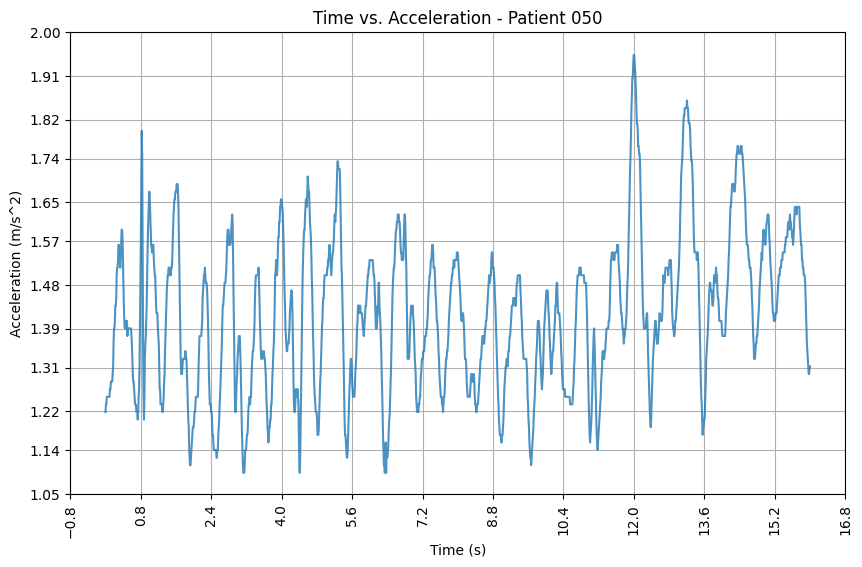

Step Count (Total) -- walk_mod : 21
Average Stride Time: 0.7604999999999563


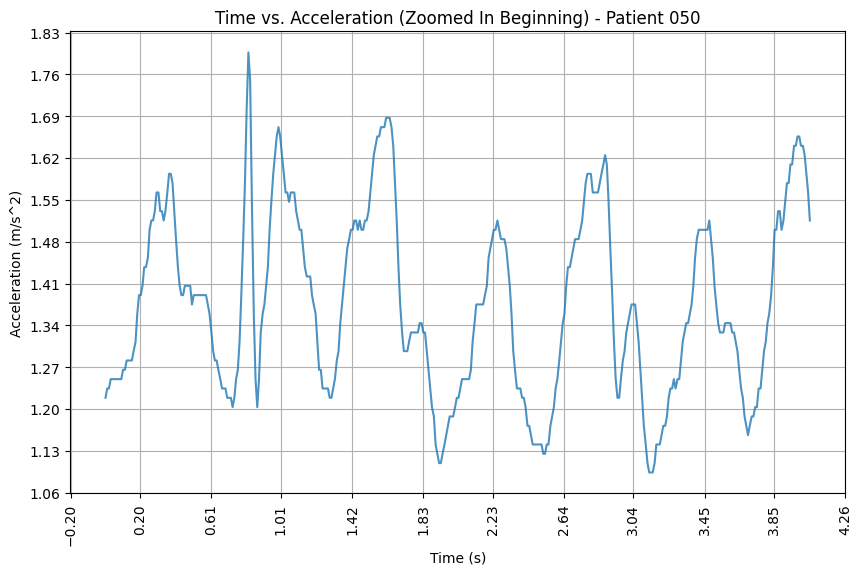

Step Count (Beginning) -- walk_mod : 7


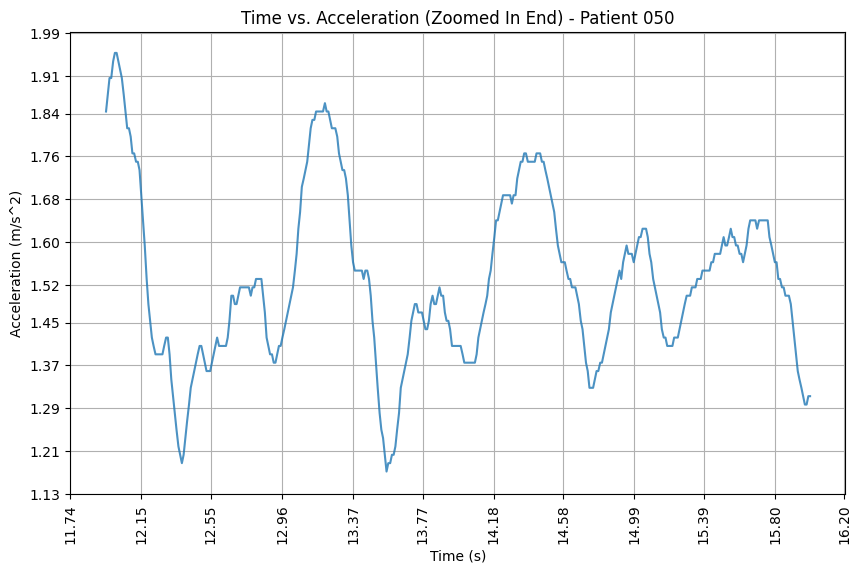

Step Count (End) -- walk_mod : 5


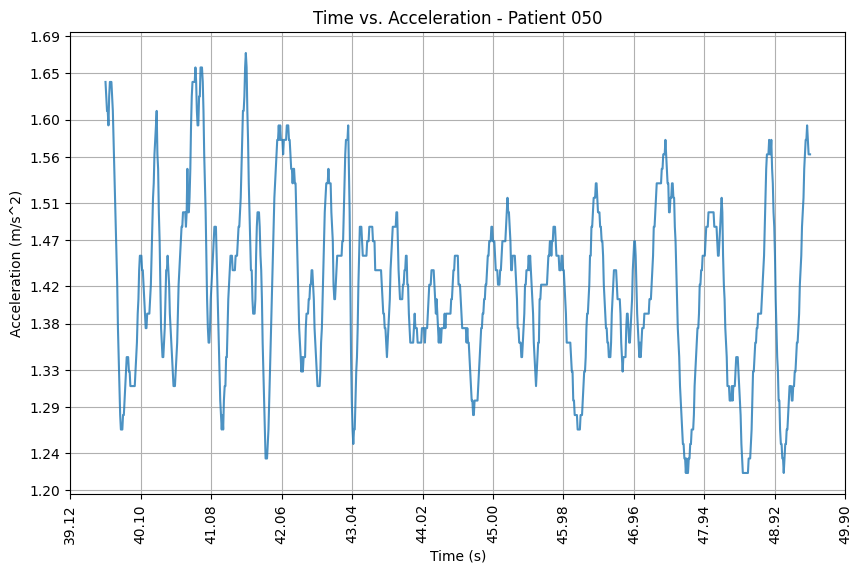

Step Count (Total) -- walk_slow : 12
Average Stride Time: 0.8844545454544872


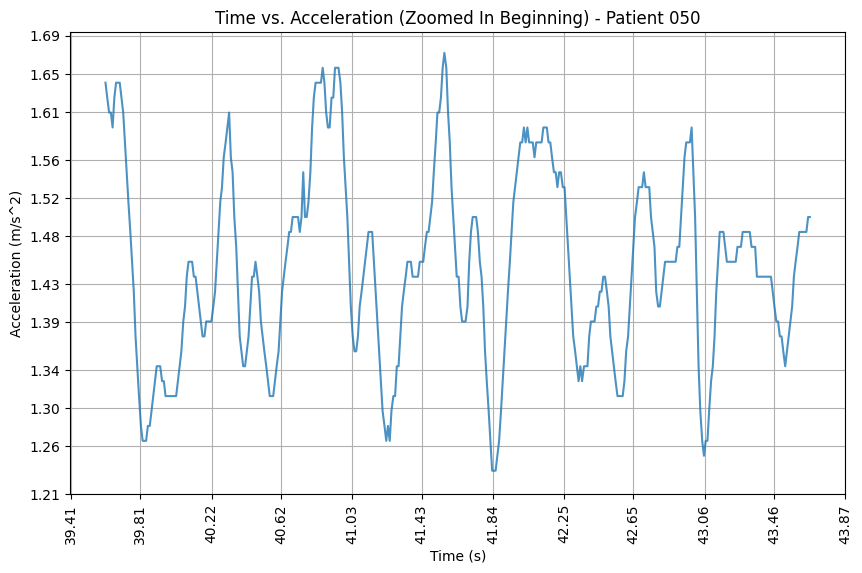

Step Count (Beginning) -- walk_slow : 5


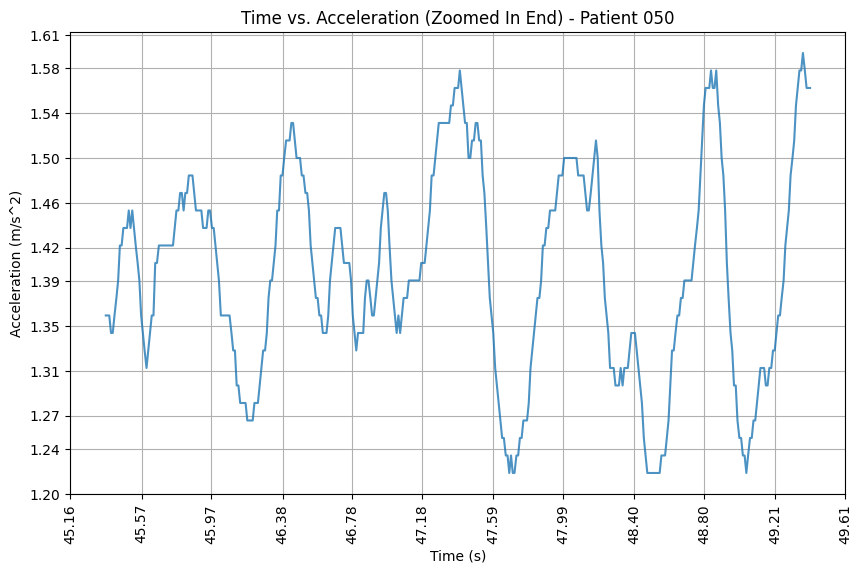

Step Count (End) -- walk_slow : 5


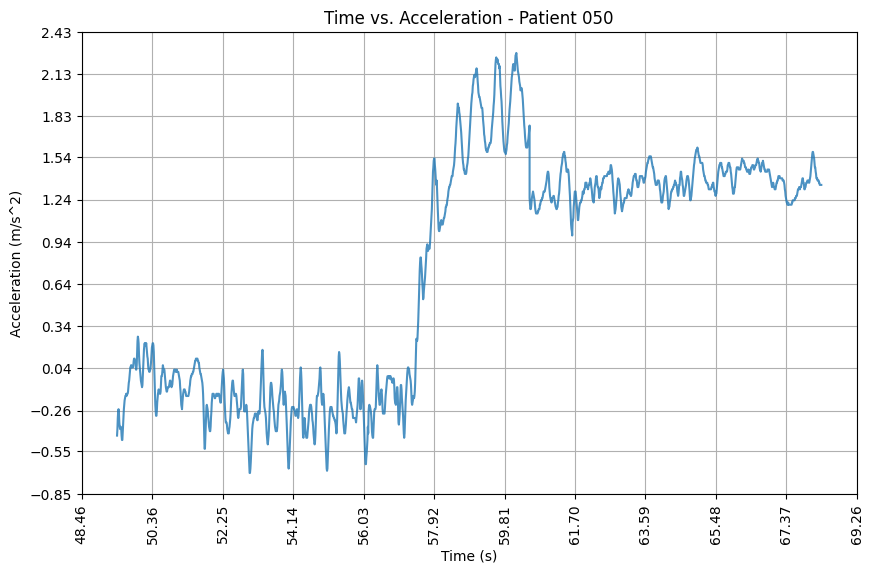

Step Count (Total) -- walk_mod : 27
Average Stride Time: 0.6971923076923233


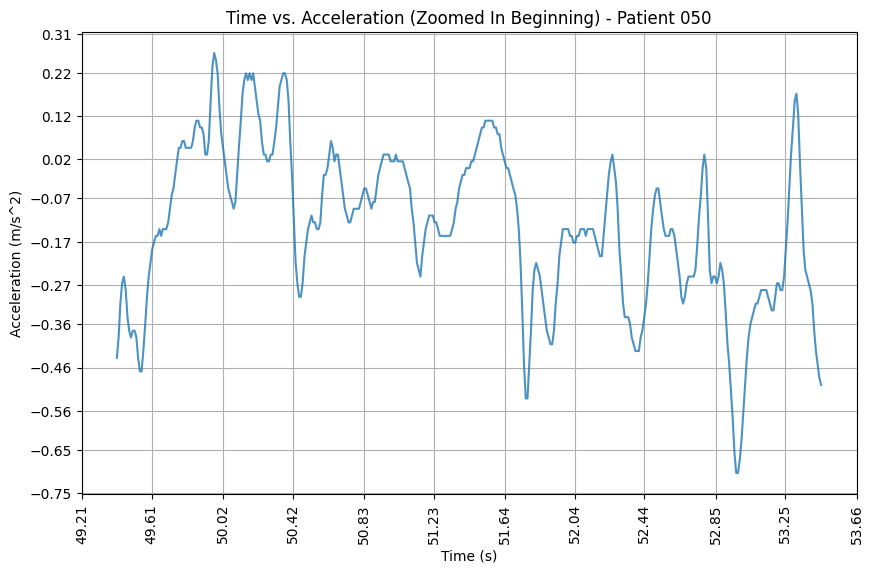

Step Count (Beginning) -- walk_mod : 6


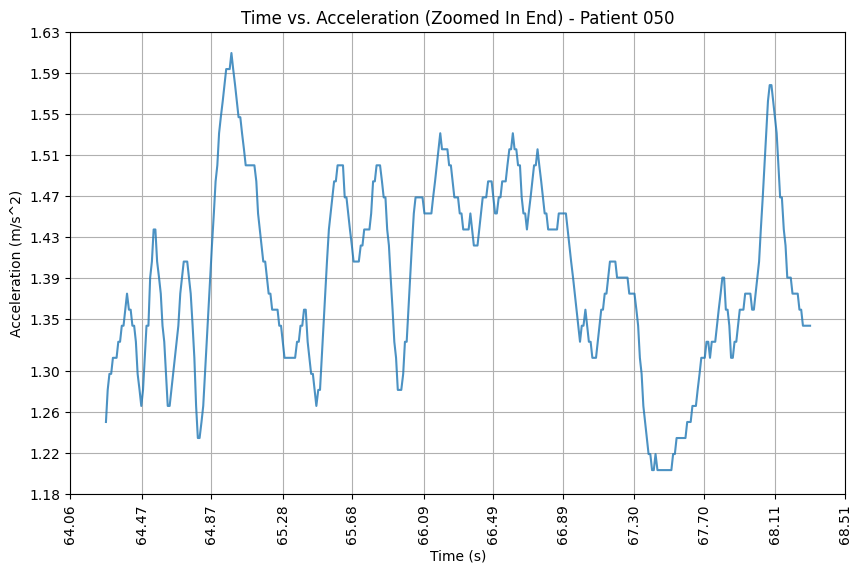

Step Count (End) -- walk_mod : 7


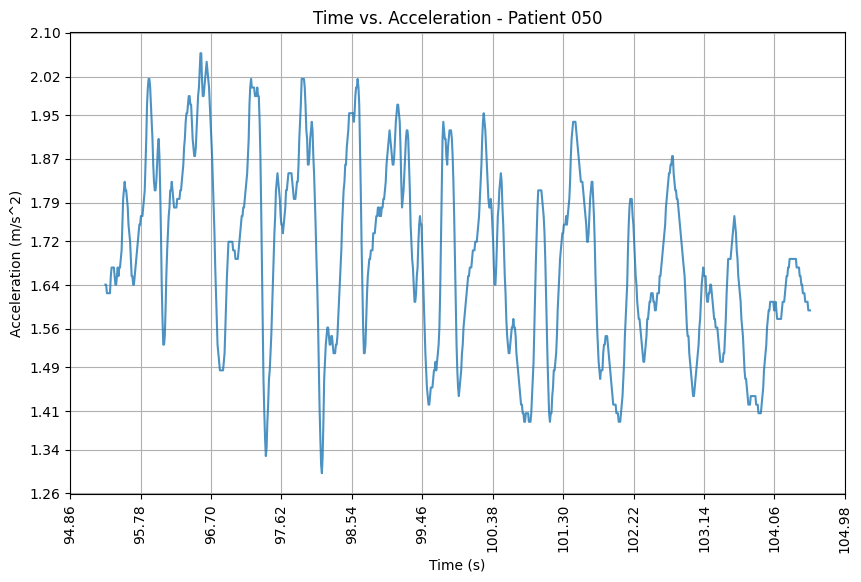

Step Count (Total) -- walk_mod : 12
Average Stride Time: 0.7625454545453646


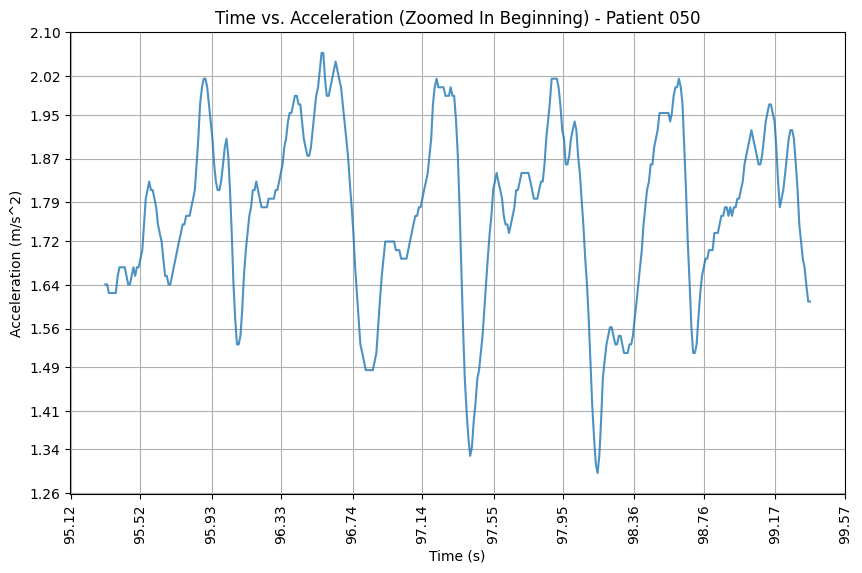

Step Count (Beginning) -- walk_mod : 6


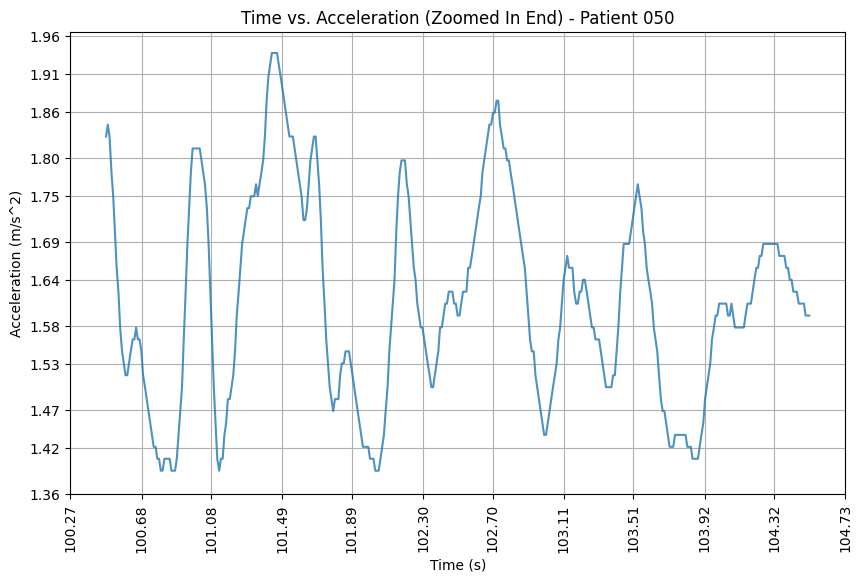

Step Count (End) -- walk_mod : 7


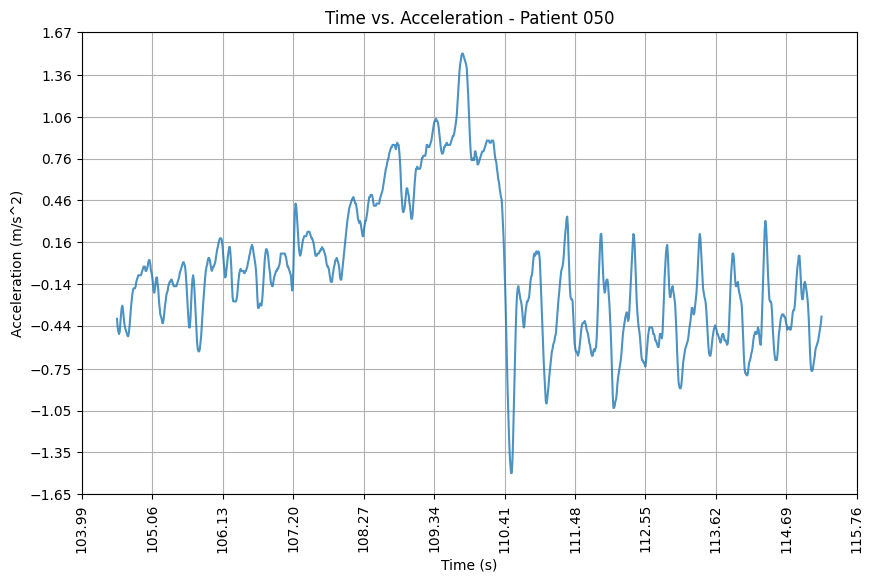

Step Count (Total) -- walk_fast : 20
Average Stride Time: 0.5281578947370259


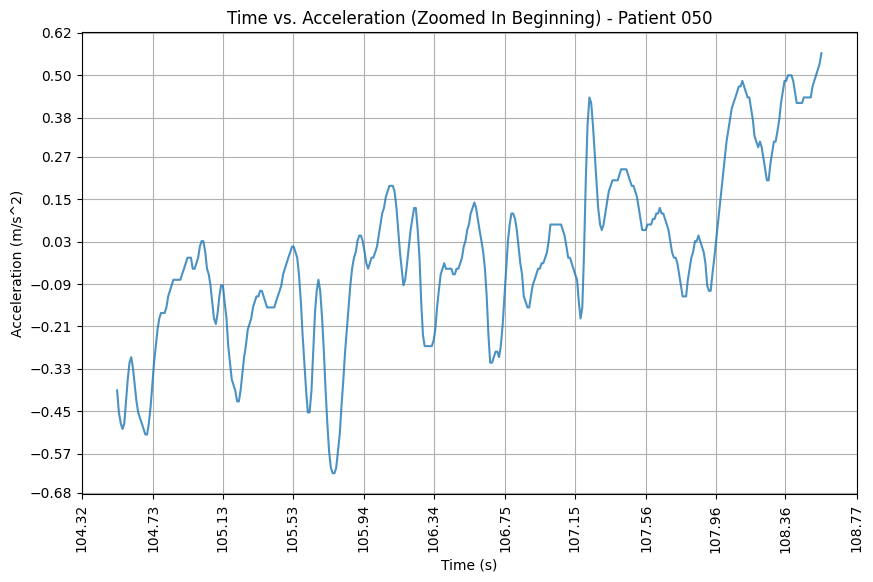

Step Count (Beginning) -- walk_fast : 8


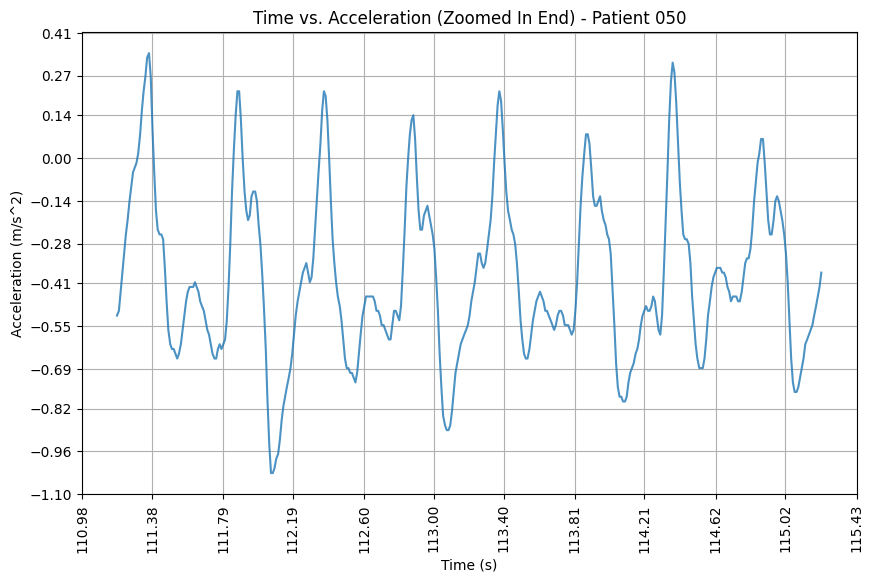

Step Count (End) -- walk_fast : 8


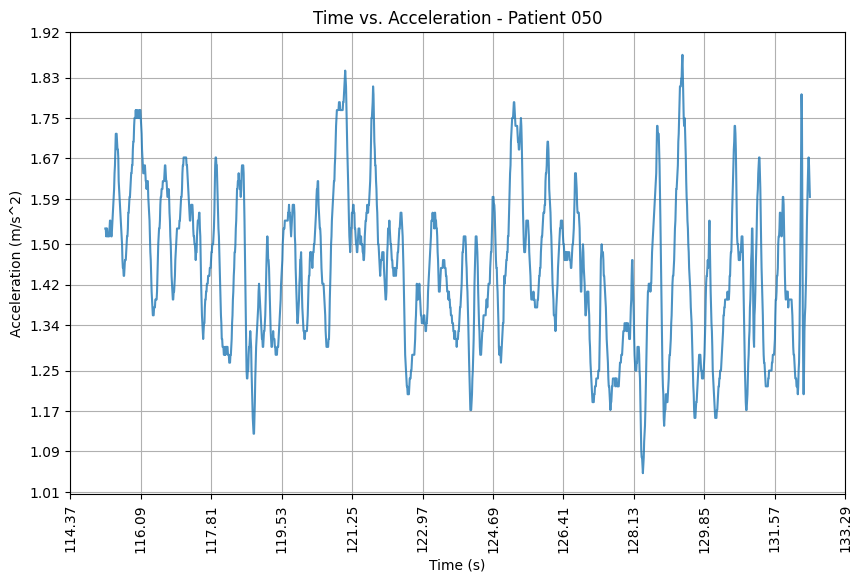

Step Count (Total) -- walk_mod : 27
Average Stride Time: 0.6439999999999529


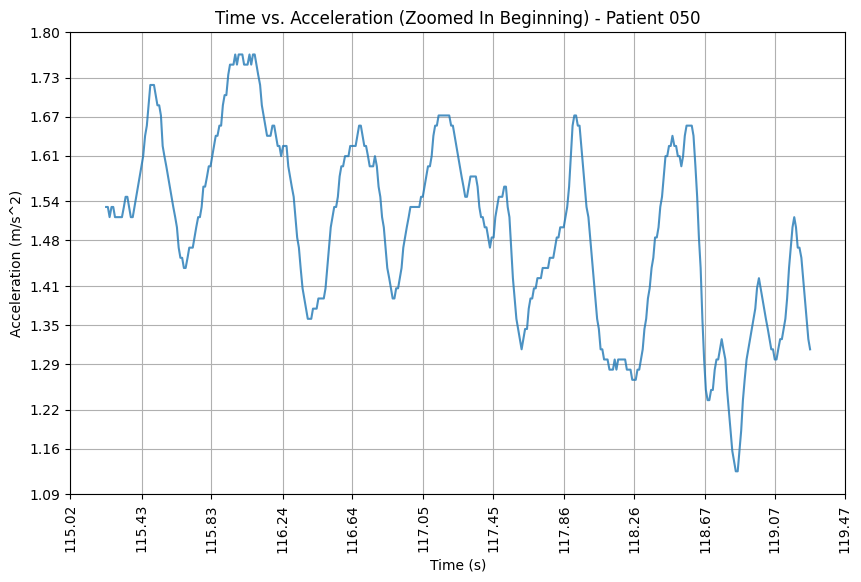

Step Count (Beginning) -- walk_mod : 7


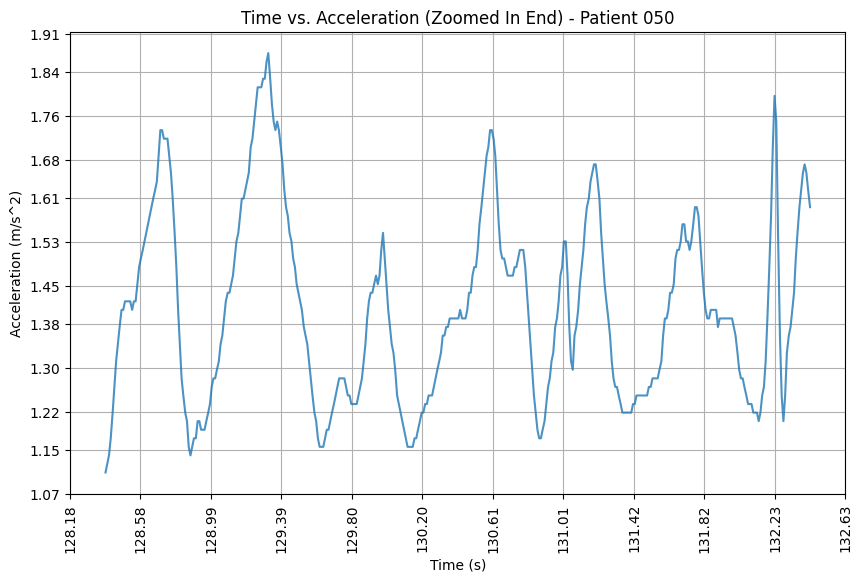

Step Count (End) -- walk_mod : 7


In [16]:
# iterates through desired number of patients
for i in range(0,1):

    # iterates through activities
    for activity_index in range(len(activities_by_patient[i])):

        # checks if an activity is walking
        curr_activity = activities_by_patient[i][activity_index]
        if ((curr_activity == "walk_slow") or (curr_activity == "walk_mod") or (curr_activity == "walk_fast")):

            # sets walking index
            walking_index = activity_index

            # holds all of current patient's data
            single_patient_data = sub_sampling_data[i]

            # sets upper and lower multipliers for the algorithm
            upper_multiplier = 0.1
            lower_multiplier = 0.1

            # sets the increment value based on the walking speed
            if (curr_activity == "walk_fast"):
                increment_by = 40
            elif (curr_activity == "walk_slow"):
                increment_by = 80
            elif (curr_activity == "walk_mod"):
                increment_by = 60
            
            # sets the end index for the walking segment
            if (walking_index + 1) == len(activities_by_patient[i]):
                end = len(single_patient_data)
            else:
                end = time_ranges[i][walking_index + 1]
                
            # determines entire time range for walking segment
            time = single_patient_data[:,0][time_ranges[i][walking_index]:end].astype(float)

            # creates a list holding the values of the relevant metrics for walking
            vector_sum = []
            for index in range(time_ranges[i][walking_index],end):
                x = float(single_patient_data[:,1][index])

                # isolates patient movement in the direction of gravity
                y = float(single_patient_data[:,2][index]) + 1

                z = float(single_patient_data[:,3][index])
                vector_sum.append(y)

            # creates a numpy array out of the list
            magnitude = np.array(vector_sum)

            # changes figure size to make it larger than default
            plt.figure(figsize=(10,6))

            # calls plotting function for each series (x, y, and z) with time on the x-axis
            plt.plot(time, magnitude, alpha=0.8)

            # sets title of graph
            title = "Time vs. Acceleration - Patient " + str(single_patient_data[0,5])
            plt.title(title)

            # sets axes labels
            plt.xlabel('Time (s)')
            plt.ylabel('Acceleration (m/s^2)')

            # sets number of tickmarks for x and y axes
            m = 12
            xmin, xmax = plt.xlim()
            plt.xticks(np.round(np.linspace(xmin, xmax, m), 2))

            n = 12
            ymin, ymax = plt.ylim()
            plt.yticks(np.round(np.linspace(ymin, ymax, n), 2))
            
            # rotates x tickmarks 90 degrees
            plt.xticks(rotation = 90)

            # plots a grid and displays the graph
            plt.grid()
            plt.show()

            # initializes variables for the algorithm
            step_count = 0
            active_counter = False
            thres_updated = False
            thres_index = 0
            stride_times = []

            # iterates through numpy array
            for mag_index in range(len(magnitude)):

                # checks if the threshold has been updated
                if (mag_index > thres_index + increment_by):
                    thres_updated = False
                
                # sets upper and lower thresholds if they are not updated
                if (thres_updated == False):

                    upper = mag_index + increment_by
                    if(upper > len(magnitude)):
                        upper = len(magnitude)
                    
                    max_val = magnitude[mag_index:upper].max()
                    min_val = magnitude[mag_index:upper].min()

                    thres_index = mag_index

                    upper_threshold = max_val - (max_val - min_val) * upper_multiplier
                    lower_threshold = min_val + (max_val - min_val) * lower_multiplier

                    thres_updated = True
                
                # sets the active counter variable to show whether it is in the middle of a wave or not
                if(magnitude[mag_index] < lower_threshold):
                    active_counter = False

                # increases step count if counter is not active and sets counter to active
                if ((active_counter == False) and (magnitude[mag_index] > upper_threshold)):
                    step_count += 1
                    stride_times.append(float(single_patient_data[:,0][mag_index]))
                    active_counter = True

            # creates an array for stride lengths based on differences in stride times
            stride_lengths = []
            for index in range(len(stride_times) - 1):
                stride_lengths.append(stride_times[index+1]-stride_times[index])

            # determines average stride time
            stride_lengths_np = np.array(stride_lengths)
            avg_stride_time = np.mean(stride_lengths)

            print("Step Count (Total) --", curr_activity, ":", step_count)
            print("Average Stride Time:", avg_stride_time)
            


            # zoomed in beginning
            # determines beginning time range for walking segment
            time = single_patient_data[:,0][time_ranges[i][walking_index]:time_ranges[i][walking_index]+ 400].astype(float)

            # creates a list holding the values of the relevant metrics for walking
            vector_sum = []
            for index in range(time_ranges[i][walking_index],time_ranges[i][walking_index]+ 400):
                x = float(single_patient_data[:,1][index])

                # isolates patient movement in the direction of gravity
                y = float(single_patient_data[:,2][index]) + 1

                z = float(single_patient_data[:,3][index])
                vector_sum.append(y)

            # creates a numpy array out of the list
            magnitude = np.array(vector_sum)

            # changes figure size to make it larger than default
            plt.figure(figsize=(10,6))

            # calls plotting function for each series (x, y, and z) with time on the x-axis
            plt.plot(time, magnitude, alpha=0.8)

            # sets title of graph
            title = "Time vs. Acceleration (Zoomed In Beginning) - Patient " + str(single_patient_data[0,5])
            plt.title(title)

            # sets axes labels
            plt.xlabel('Time (s)')
            plt.ylabel('Acceleration (m/s^2)')

            # sets number of tickmarks for x and y axes
            m = 12
            xmin, xmax = plt.xlim()
            plt.xticks(np.round(np.linspace(xmin, xmax, m), 2))

            n = 12
            ymin, ymax = plt.ylim()
            plt.yticks(np.round(np.linspace(ymin, ymax, n), 2))

            # rotates x tickmarks 90 degrees
            plt.xticks(rotation = 90)

            # plots a grid and displays the graph
            plt.grid()
            plt.show()

            # initializes variables for the algorithm
            step_count = 0
            active_counter = False
            thres_updated = False
            thres_index = 0

            # iterates through numpy array
            for mag_index in range(len(magnitude)):

                # checks if the threshold has been updated
                if (mag_index > thres_index + increment_by):
                    thres_updated = False
                
                # sets upper and lower thresholds if they are not updated
                if (thres_updated == False):

                    upper = mag_index + increment_by
                    if(upper > len(magnitude)):
                        upper = len(magnitude)
                    
                    max_val = magnitude[mag_index:upper].max()
                    min_val = magnitude[mag_index:upper].min()

                    thres_index = mag_index

                    upper_threshold = max_val - (max_val - min_val) * upper_multiplier
                    lower_threshold = min_val + (max_val - min_val) * lower_multiplier
                    
                    thres_updated = True
                
                # sets the active counter variable to show whether it is in the middle of a wave or not
                if(magnitude[mag_index] < lower_threshold):
                    active_counter = False

                # increases step count if counter is not active and sets counter to active
                if ((active_counter == False) and (magnitude[mag_index] > upper_threshold)):
                    step_count += 1
                    active_counter = True

            print("Step Count (Beginning) --", curr_activity, ":", step_count)



            # zoomed in end
            # determines beginning time range for walking segment
            time = single_patient_data[:,0][end-400:end].astype(float)

            # creates a list holding the values of the relevant metrics for walking
            vector_sum = []
            for index in range(end - 400,end):
                x = float(single_patient_data[:,1][index])

                # isolates patient movement in the direction of gravity
                y = float(single_patient_data[:,2][index]) + 1

                z = float(single_patient_data[:,3][index])
                vector_sum.append(y)

            # creates a numpy array out of the list
            magnitude = np.array(vector_sum)
                
            # changes figure size to make it larger than default
            plt.figure(figsize=(10,6))

            # calls plotting function for each series (x, y, and z) with time on the x-axis
            plt.plot(time, magnitude, alpha=0.8)

            # sets title of graph
            title = "Time vs. Acceleration (Zoomed In End) - Patient " + str(single_patient_data[0,5])
            plt.title(title)

            # sets axes labels
            plt.xlabel('Time (s)')
            plt.ylabel('Acceleration (m/s^2)')

            # sets number of tickmarks for x and y axes
            n = 12
            xmin, xmax = plt.xlim()
            plt.xticks(np.round(np.linspace(xmin, xmax, m), 2))

            ymin, ymax = plt.ylim()
            plt.yticks(np.round(np.linspace(ymin, ymax, n), 2))

            # rotates x tickmarks 90 degrees
            plt.xticks(rotation = 90)

            # plots a grid and displays the graph
            plt.grid()
            plt.show()

            # initializes variables for the algorithm
            step_count = 0
            active_counter = False
            thres_updated = False
            thres_index = 0

            # iterates through numpy array
            for mag_index in range(len(magnitude)):

                # checks if the threshold has been updated
                if (mag_index > thres_index + increment_by):
                    thres_updated = False
                
                # sets upper and lower thresholds if they are not updated
                if (thres_updated == False):

                    upper = mag_index + increment_by
                    if(upper > len(magnitude)):
                        upper = len(magnitude)
                    
                    max_val = magnitude[mag_index:upper].max()
                    min_val = magnitude[mag_index:upper].min()

                    thres_index = mag_index

                    upper_threshold = max_val - (max_val - min_val) * upper_multiplier
                    lower_threshold = min_val + (max_val - min_val) * lower_multiplier
                
                    thres_updated = True
                
                # sets the active counter variable to show whether it is in the middle of a wave or not
                if(magnitude[mag_index] < lower_threshold):
                    active_counter = False

                # increases step count if counter is not active and sets counter to active
                if ((active_counter == False) and (magnitude[mag_index] > upper_threshold)):
                    step_count += 1
                    active_counter = True

            print("Step Count (End) --", curr_activity, ":", step_count)

**Machine Learning [5]**

Classifier to differentiate activity type.

In [17]:
# creates a pandas dataframe out of the ml formatted array
df = pd.DataFrame(ml_format, columns = ['timestamp','x_axis','y_axis','z_axis', 'activity', 'patient', 'start_index', 'user_id'])

# deletes non-relevant columns
df = df.drop(['patient', 'start_index'], axis=1)

# reorders columns
df = df[['user_id', 'activity', 'timestamp', 'x_axis', 'y_axis', 'z_axis']]

# casts columns to their correct data types
df['user_id'] = df['user_id'].astype(int)
df['timestamp'] = df['timestamp'].astype(float)
df['x_axis'] = df['x_axis'].astype(float)
df['y_axis'] = df['y_axis'].astype(float)
df['z_axis'] = df['z_axis'].astype(float)

# generalizes all types of walking
df.loc[df["activity"] == "walk_slow", "activity"] = "walking"
df.loc[df["activity"] == "walk_mod", "activity"] = "walking"
df.loc[df["activity"] == "walk_fast", "activity"] = "walking"

# splits the train and test sets based on indices
df_train = df[df['user_id'] <= 30]
df_test = df[df['user_id'] > 30]

# scale the accelerometer data values
scale_columns = ['x_axis', 'y_axis', 'z_axis']

scaler = RobustScaler()

scaler = scaler.fit(df_train[scale_columns])

df_train.loc[:, scale_columns] = scaler.transform(
  df_train[scale_columns].to_numpy()
)

df_test.loc[:, scale_columns] = scaler.transform(
  df_test[scale_columns].to_numpy()
)

# define create_dataset function
def create_dataset(X, y, time_steps=1, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        v = X.iloc[i:(i + time_steps)].values
        labels = y.iloc[i: i + time_steps]
        Xs.append(v)
        ys.append(stats.mode(labels)[0][0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)

# create the sequences
TIME_STEPS = 200
STEP = 40

X_train, y_train = create_dataset(
    df_train[['x_axis', 'y_axis', 'z_axis']],
    df_train.activity,
    TIME_STEPS,
    STEP
)

X_test, y_test = create_dataset(
    df_test[['x_axis', 'y_axis', 'z_axis']],
    df_test.activity,
    TIME_STEPS,
    STEP
)

# prints shape of new sequences
print(X_train.shape, y_train.shape)

# encodes categories
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)

enc = enc.fit(y_train)

y_train = enc.transform(y_train)
y_test = enc.transform(y_test)


# simple Bidirectional LSTM model
model = keras.Sequential()
model.add(
    keras.layers.Bidirectional(
      keras.layers.LSTM(
          units=128,
          input_shape=[X_train.shape[1], X_train.shape[2]]
      )
    )
)
model.add(keras.layers.Dropout(rate=0.5))
model.add(keras.layers.Dense(units=128, activation='relu'))
model.add(keras.layers.Dense(y_train.shape[1], activation='softmax'))

model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['acc']
)

# actual training process
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.1,
    shuffle=False
)


/Users/tanviranade/anaconda3/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
/Users/tanviranade/anaconda3/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
/var/folders/jl/hp2wr3zd4fv89hw1wtzqzg3c0000gn/T/ipykernel_88371/2799575276.py:48: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  ys.append(stats.mode(labels)[0][0])
/var/folders/jl/hp2wr3zd4fv89hw1wtzqzg3c0000gn/T/ipykernel_88371/2799575276.py:48

(13919, 200, 3) (13919, 1)


/Users/tanviranade/anaconda3/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Epoch 1/20
392/392 [==============================] - 23s 52ms/step - loss: 0.9266 - acc: 0.5958 - val_loss: 0.9086 - val_acc: 0.4016
Epoch 2/20
392/392 [==============================] - 19s 49ms/step - loss: 0.7887 - acc: 0.6574 - val_loss: 0.8047 - val_acc: 0.5546
Epoch 3/20
392/392 [==============================] - 22s 55ms/step - loss: 0.7475 - acc: 0.6649 - val_loss: 0.7755 - val_acc: 0.6379
Epoch 4/20
392/392 [==============================] - 20s 52ms/step - loss: 0.8673 - acc: 0.6154 - val_loss: 1.0593 - val_acc: 0.4555
Epoch 5/20
392/392 [==============================] - 20s 52ms/step - loss: 0.9721 - acc: 0.5468 - val_loss: 0.9331 - val_acc: 0.4569
Epoch 6/20
392/392 [==============================] - 19s 49ms/step - loss: 0.8973 - acc: 0.5970 - val_loss: 0.8372 - val_acc: 0.5438
Epoch 7/20
392/392 [==============================] - 26s 66ms/step - loss: 0.8231 - acc: 0.6073 - val_loss: 0.7974 - val_acc: 0.5474
Epoch 8/20
392/392 [==============================] - 25s 63ms

In [18]:
# evaluates accuracy
model.evaluate(X_test, y_test)


970/970 [==============================] - 24s 25ms/step - loss: 0.5841 - acc: 0.7112


[0.5840553045272827, 0.7112229466438293]

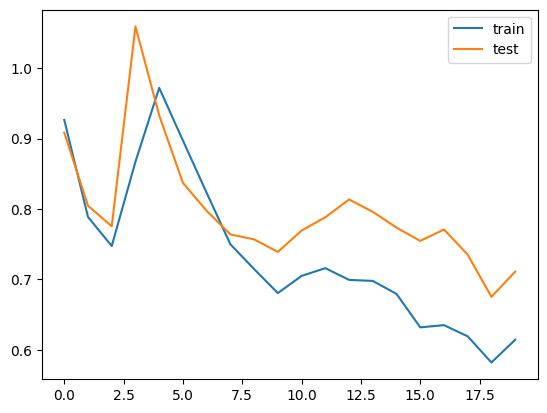

In [19]:
# shows the history graph
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

970/970 [==============================] - 22s 22ms/step


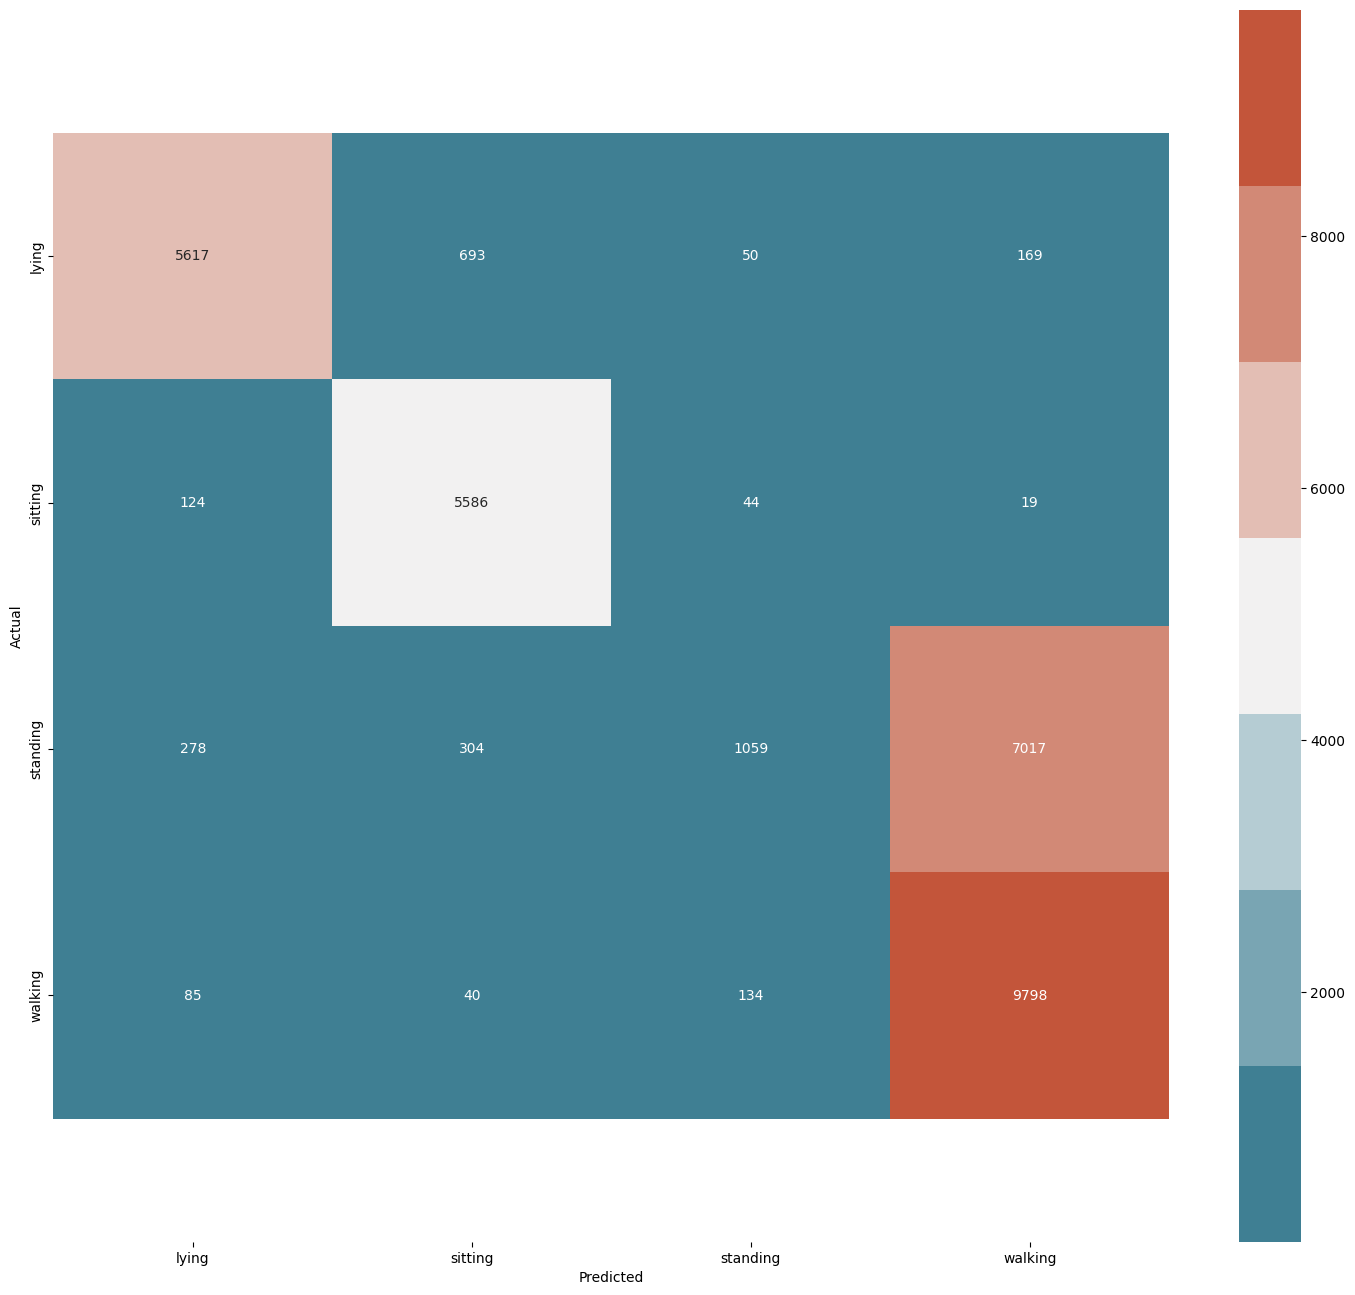

In [20]:

# shows the confusion matrix
y_pred = model.predict(X_test)

def plot_cm(y_true, y_pred, class_names):
  cm = confusion_matrix(y_true, y_pred)
  fig, ax = plt.subplots(figsize=(18, 16)) 
  ax = sns.heatmap(
      cm, 
      annot=True, 
      fmt="d", 
      cmap=sns.diverging_palette(220, 20, n=7),
      ax=ax
  )

  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  ax.set_xticklabels(class_names)
  ax.set_yticklabels(class_names)
  b, t = plt.ylim() # discover the values for bottom and top
  b += 0.5 # Add 0.5 to the bottom
  t -= 0.5 # Subtract 0.5 from the top
  plt.ylim(b, t) # update the ylim(bottom, top) values
  plt.show() # ta-da!

plot_cm(
    enc.inverse_transform(y_test),
    enc.inverse_transform(y_pred),
    enc.categories_[0]
)